### Pulling in LEV files and to Construct Deployment, Well, and Data Models

In [176]:
import pandas as pd
import numpy as np
import os, glob, linecache, uuid
import xml.etree.ElementTree as ETE
import seaborn as sns
import matplotlib.pyplot as plt

uuid_gen = uuid.uuid4()

In [177]:
data_dir = "C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets"

In [178]:
LEV_dir_list = glob.glob(f"{data_dir}/*/*.lev")
XLE_dir_list = glob.glob(f"{data_dir}/*/*.xle") + glob.glob(f"{data_dir}/*/*/*.xle")
XLSX_dir_list = glob.glob(f"{data_dir}/WellsData_Dudek_2009-2011/*.xlsx")
CSV_dir_2017_2018_list = glob.glob(f"{data_dir}/WellsData_2017-2018/*.csv")

In [179]:
processed = set([os.path.basename(file) for file in LEV_dir_list + XLE_dir_list + XLSX_dir_list + CSV_dir_2017_2018_list])
unprocessed_list = [glob.glob(f"{data_dir}/*/*.{ext}") for ext in ["xlsx", "lev", "xle", "csv"]] + [glob.glob(f"{data_dir}/*/*/*.xle")]
unprocessed = set()
for ext in unprocessed_list:
    unprocessed.update([os.path.basename(file) for file in ext])

unprocessed = unprocessed.difference(processed)
unprocessed

{'2021-03-24-Oaks3.csv',
 'Oaks1_2021_12_05.csv',
 'Oaks3B_Level_SN2035479_2020-07-03Compensated_mat.xlsx',
 'Sheep camp11-10excelDataExplained_Temperature.xlsx',
 'Tinta5_2010_05_16.csv',
 'Water Levels end March 2015.xlsx',
 'quail cyn example data explained.xlsx'}

In [180]:

with open(f"{data_dir}/SynthesisStatus.txt", "w") as output:
    output.write("Unprocessed datasheets \n")
    for file in unprocessed:
        output.write(str(file) + "\n")
    output.write("Emails\n")
    output.write("\nProcessed datasheets \n")
    for file in processed:
        output.write(str(file) + "\n")

In [181]:
def find_data_rows(lines):
    i = 0 
    while i < len(lines):
        if lines[i] == "[Data]\r\n":
            return i 
        i += 1

In [182]:
Wells = pd.DataFrame()
Devices = pd.DataFrame()
WellData = {}

for lev in LEV_dir_list:
    with open(lev, newline="\n") as lev_text:
        lev_lines = lev_text.readlines()
        _dataStart = find_data_rows(lev_lines) + 2
        
        _metadata = {}
        for _mdx in lev_lines[10:_dataStart]:
            _spltKeyDat = _mdx.replace(" ", "").strip().split("=")
            if len(_spltKeyDat) > 1:
                if _spltKeyDat[0] == "Unit" and "LevelUnit" in _metadata.keys() :
                    _spltKeyDat[0] = "TemperatureUnit"
                elif _spltKeyDat[0] == "Unit":
                    _spltKeyDat[0] = "LevelUnit"
                _metadata[_spltKeyDat[0]] = _spltKeyDat[1]
        
        instrumentType = _metadata.get("Instrumenttype") or "Unknown"
        location = (_metadata.get("Location") or "Unknown").replace("/", "").replace("#", "")
        altitude = _metadata.get("Altitude", 0)
        levelUnit = _metadata.get("LevelUnit", "unit")
        tempUnit = _metadata.get("TemperatureUnit", "unit")
        dateStarted = _metadata.get("StartTime", None)
        dateUpdated = _metadata.get("StopTime", None)

        ## Find Data Pointer

        _df = pd.read_fwf(lev, skiprows=_dataStart, names=["date", "time", "level", "temperature"], encoding='iso-8859-1')
        _df = _df.iloc[:-1]
        _df = _df.set_index(_df.agg(('{0[date]}{0[time]}' + f"{location}{instrumentType}").format, axis=1).apply(lambda x: hash(x)))

        if os.path.exists(f"{data_dir}/HistoricalWellSynthesis/Data/{location}/{location}.csv") :
            WellData[location] = pd.read_csv(f"{data_dir}/HistoricalWellSynthesis/Data/{location}/{location}.csv")
        elif not os.path.exists(f"{data_dir}/HistoricalWellSynthesis/Data/{location}"):
            os.makedirs(f"{data_dir}/HistoricalWellSynthesis/Data/{location}")
            
        if location in WellData.keys():
            WellData[location] = pd.concat([WellData[location], _df], axis=0)
        else: 
            WellData[location] = _df
            
        Devices = pd.concat([Devices, pd.DataFrame({
            "instrumentType":instrumentType,
            "location": location,
            "altitude": altitude,
            "levelUnit": levelUnit,
            "temperatureUnit": tempUnit,
            "dateStarted": dateStarted,
            "dateUpdated": dateUpdated
        }, index=[instrumentType+location])], ignore_index = True)
        
#         print(location)

In [183]:
import xml_to_dict

parser = xml_to_dict.XMLtoDict()

for xle in XLE_dir_list:
    
    with open(xle, newline="\n") as xle_text:
        xle_content = xle_text.read()
        xle_dict = parser.parse(xle_content)['Body_xle']
        
        instrumentType = (xle_dict.get('Instrument_info', {}).get('Instrument_type') or "Unknown")
        location = (xle_dict.get('Instrument_info_data_header', {}).get('Location') or "Unknown").replace("/", "").replace("#", "")
        altitude = xle_dict.get('Ch1_data_header', {}).get('Parameters', {}).get('Altitude', 0)
        
        levelUnit = xle_dict.get('Ch1_data_header', {}).get('Unit', 'unit')
        tempUnit = xle_dict.get('Ch2_data_header', {}).get('Unit', 'unit')
        
        dateUpdated = xle_dict.get("Instrument_info_data_header", {}).get('Stop_time') or 'Unknown'
        dateStarted = xle_dict.get("Insturment_info_data_header", {}).get('Start_time') or 'Unknown'
        
        _df = pd.DataFrame(xle_dict.get('Data', {}).get('Log', {}))
        _df = _df.set_index(_df.agg(('{0[Date]}{0[Time]}' + f"{location}{instrumentType}").format, axis=1).apply(lambda x: hash(x)))
        _df = _df.rename(columns = {"Date": 'date', "Time":'time', "ch1":"level", 'ch2':'temperature' }).drop(['ms', '@id'], axis=1)
        
        if os.path.exists(f"{data_dir}/HistoricalWellSynthesis/Data/{location}/{location}.csv") :
            WellData[location] = pd.read_csv(f"{data_dir}/HistoricalWellSynthesis/Data/{location}/{location}.csv")
        elif not os.path.exists(f"{data_dir}/HistoricalWellSynthesis/Data/{location}"):
            os.makedirs(f"{data_dir}/HistoricalWellSynthesis/Data/{location}")
            
        if location in WellData.keys():
            WellData[location] = pd.concat([WellData[location], _df], axis=0)
        else: 
            WellData[location] = _df
            
        Devices = pd.concat([Devices, pd.DataFrame({
            "instrumentType":instrumentType,
            "location": location,
            "altitude": altitude,
            "levelUnit": levelUnit,
            "temperatureUnit": tempUnit,
            "dateStarted": dateStarted,
            "dateUpdated": dateUpdated
        }, index=[instrumentType+location])], ignore_index = True)

C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\2016-09-13_WellsDataDownload\20160913esc#2.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\2016-09-13_WellsDataDownload\20160913esc#5.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\2016-09-13_WellsDataDownload\20160913escondido#3a.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\2016-09-13_WellsDataDownload\20160913escondido#3b.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\2016-09-13_WellsDataDownload\20160913venidito#2.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\2016-09-13_WellsDataDownload\20160914lowerjalama_vaquero.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\2016-09-13_WellsDataDownload\20160914oaks#1.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\2016-09-13_WellsDataDownload\20160914oaks#2.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\2016-09-13_WellsDataDownload\20160914oaks#3b.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\2016-09-13_WellsDataDownload\20160914oaks#4.xle
C:

C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\WellsDatafromTracy\2016_sept_wells\20160913escondido#3b.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\WellsDatafromTracy\2016_sept_wells\20160913venidito#2.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\WellsDatafromTracy\2016_sept_wells\20160914lowerjalama_vaquero.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\WellsDatafromTracy\2016_sept_wells\20160914oaks#1.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\WellsDatafromTracy\2016_sept_wells\20160914oaks#2.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\WellsDatafromTracy\2016_sept_wells\20160914oaks#3b.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\WellsDatafromTracy\2016_sept_wells\20160914oaks#4.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\WellsDatafromTracy\2016_sept_wells\20160914quail.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets\WellsDatafromTracy\2016_sept_wells\20160914tinta#11.xle
C:/Users/jinsu.elhance/Box/Wells/WellsDatasheets

In [184]:
for xlsx in XLSX_dir_list:
    _df = pd.read_excel(xlsx, sheet_name = "data")
    _df = _df[["DATE TIME", "Level (ft)", "Temperature °C", "DATE TIME.1", "Barologger Level (ft)", "Barologger Corrected for Elevation", "Temperature °C.1", "Corrected Water Level (ft H2O)", "Groundwater Elevation (ft MSL)"]]
    
    _df.loc[_df['DATE TIME.1'].isna(), 'DATE TIME.1'] = _df.loc[_df['DATE TIME.1'].isna(), 'DATE TIME']
    _df.loc[_df['DATE TIME'].isna(), 'DATE TIME'] = _df.loc[_df['DATE TIME'].isna(), 'DATE TIME.1']
    _df['date'] = _df['DATE TIME'].dt.date
    _df['time'] = _df['DATE TIME'].dt.time
    
    _df = _df.rename(columns = {
        'Level (ft)': 'level', 
        'Temperature °C':'temperature', 
        'Barologger Level (ft)':'barologger_level', 
        'Barologger Corrected for Elevation': 'barologger_level_c_elevation',
        'Temperature °C.1':'temperature_surface',
        'Corrected Water Level (ft H2O)': 'level_corrected',
        'Groundwater Elevation (ft MSL)': 'groundwater_elevation'}
        )[['date','time','level','temperature','barologger_level','barologger_level_c_elevation','temperature_surface','level_corrected','groundwater_elevation']]
    
    location = xlsx.split("\\")[1][:-5].replace("_","")
    
    if os.path.exists(f"{data_dir}/HistoricalWellSynthesis/Data/{location}/{location}.csv") :
        WellData[location] = pd.read_csv(f"{data_dir}/HistoricalWellSynthesis/Data/{location}/{location}.csv")
    elif not os.path.exists(f"{data_dir}/HistoricalWellSynthesis/Data/{location}"):
        os.makedirs(f"{data_dir}/HistoricalWellSynthesis/Data/{location}")

    if location in WellData.keys():
        WellData[location] = pd.concat([WellData[location], _df], axis=0)
    else: 
        WellData[location] = _df
        
#     print(location)

In [185]:
# Devices = Devices.set_index(Devices["instrumentType"] + Devices["location"])
#Write LEVs to csvs
full_well_data = pd.DataFrame()
for Well, Data in WellData.items():
    Data.to_csv(f"{data_dir}/HistoricalWellSynthesis/Data/{Well}/{Well}.csv")
    Data["Well"] = Well
    full_well_data = pd.concat([full_well_data, Data])
# Devices.to_csv("Data/Devices.csv")

In [186]:
full_well_data = full_well_data.loc[~full_well_data['time'].isna()]
full_well_data['datetime'] = pd.to_datetime(full_well_data['date'].astype(str) + " " + full_well_data['time'].astype(str));

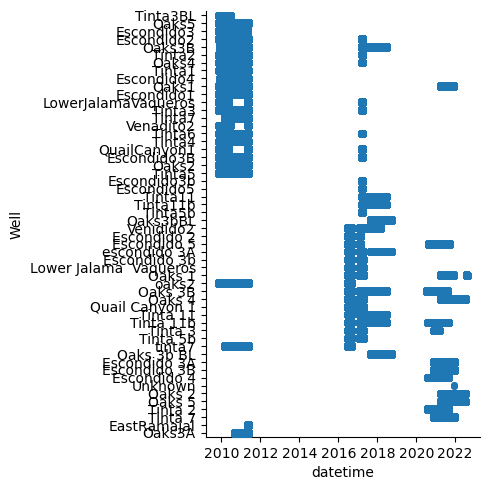

In [187]:
well_periods = sns.catplot(data=full_well_data, x='datetime', y='Well')
plt.show()